Semantic JsonSchema types in python.

In [1]:
    class Schema(__import__('munch').Munch):
        """>>> schema = Schema({'type': 'object'})
        >>> assert schema.valid({})
        >>> assert not schema.valid(1)
        
        """
        __validator_cls__ = __import__('jsonschema').Draft7Validator
        __validator__ = None
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.__validator__ = self.__validator_cls__(self, format_checker=__import__('jsonschema').draft7_format_checker)
            self.__validator__.check_schema(self)
        @property
        def validate(self): return self.__validator__.validate
        def valid(cls, object) -> bool:
            """A boolean version of validate.  Validate object against a schema without raising an Exception."""
            try: cls.validate(object); return True
            except __import__('jsonschema').ValidationError: return False
            
        def __and__(self, object):
            if 'allOf' is self: self['allOf'].append(object)
            return Schema(allOf=[self, getattr(object, '__schema__', object)])
        
        def __or__(self, object):
            if 'anyOf' is self: self['anyOf'].append(object)
            return Schema(anyOf=[self, getattr(object, '__schema__', object)])

In [2]:
    class VerifySchema:
        def __init_subclass__(cls, **kwargs):
            cls.__rdf__ = kwargs.pop('__rdf__', None)
            schema = Schema(**kwargs)
            if cls.__doc__: schema['description'] = cls.__doc__ 
            for object in reversed(cls.__mro__):  schema.update(getattr(object, '__schema__', {}))
            schema.title = cls.__name__
            cls.__schema__ = schema
            
    class JsonSchema(VerifySchema, __import__('abc').ABCMeta): 
        def new(cls, object=None, **schema):  return type(schema.get('title', __import__('json').dumps(schema)), (cls,), {}, **schema)
        def __and__(self, object): return self.__schema__ & object
        def __or__(self, object): return self.__schema__ | object


In [3]:
    class Type(VerifySchema, metaclass=JsonSchema, __rdf__='http://www.w3.org/1999/02/22-rdf-syntax-ns#type'): 
        __schema__ = Schema()
        __rdf__ = None
        def __new__(cls, object=None, *args, **kwargs):
            if object is None: object = __import__('copy').copy(cls.__schema__.get('default', None))
            if issubclass(cls, Dict):  
                object = object or {}
                for kwargs in (kwargs, *args): object.update(kwargs)
            cls.__schema__.validate(object)
            self = super().__new__(cls, object, *args, **kwargs)
            self.__init__(*args, **kwargs)
            return cls.__schema__.validate(self) or self
        
        @classmethod
        def object(self, object=None, **schema):
            for cls in (self.__subclasses__()):
                try: object = cls(object); break
                except BaseException as e: ...
            else: return object
            return cls.object(object)
        
    class Contextual:
        def __new__(cls, object=None, *args, **kwargs): 
            object = super().__new__(cls, object, *args, **kwargs)
            object.__context__ = getattr(object, '__context__', {})
            return object
        
        def __matmul__(self, object):
            self.__context__.update(object)
            return self
        
        def expand(self, ctx=None):
            return List(__import__('pyld').jsonld.expand(self, options=dict(expandContext={**self.__context__, **(ctx or {})})))
        def compact(self, ctx):
            return Dict(
                __import__('pyld').jsonld.compact(self, ctx, options=dict(expandContext=self.__context__)),
                **{'@type': self.__rdf__}
            )
            
            
    class List(Contextual, Type, list, type='array', default=[], __rdf__='http://www.w3.org/1999/02/22-rdf-syntax-ns#List'): 
        def __new__(cls, object=None, *args, **kwargs): 
            if isinstance(object, tuple): object = list(object)
            return super().__new__(cls, object, *args, **kwargs)        
    
    class Object:
        def __init_subclass__(cls, **schema): 
            cls.__schema__ = Schema(getattr(cls, '__schema__', {}))
            cls.__schema__.update(schema, type='object', properties={
                key: value.__schema__ for key, value in getattr(cls, '__annotations__', {}).items() if hasattr(value, '__schema__')
            })
            cls.__schema__.validate(schema)


    class Dict(Contextual, Object, Type, dict, default={}, __rdf__='http://www.w3.org/2000/01/rdf-schema#Container'): ...

    class Null(Type, type='null', __rdf__='http://www.w3.org/1999/02/22-rdf-syntax-ns#nil'): 
        def __new__(cls, object=None, *args, **kwargs): return cls.validate(cls, object)
    class Integer(Type, int, type='integer', default='', __rdf__='http://www.w3.org/2001/XMLSchema#integer'): ...
    class Number(Type, float, type='number', default='', __rdf__='http://www.w3.org/2001/XMLSchema#float'): ...
    
    class String(Type, str, type='string', default='', __rdf__='http://www.w3.org/2000/01/rdf-schema#Literal'): ...
    
    class Uri(String, format='uri', __rdf__='http://www.w3.org/2000/01/rdf-schema#Resource'): ...
    class Date(String, format='date', __rdf__='http://www.w3.org/2001/XMLSchema#date'): ...
    class Datetime(String, format='date-time', __rdf__='http://www.w3.org/2001/XMLSchema#dateTime'): ...
    class Time(String, format='time', __rdf__='http://www.w3.org/2001/XMLSchema#time'): ...
    class Email(String, format='email', __rdf__='http://www.w3.org/2006/vcard/ns#Email'): ...
        
    class File(String, __rdf__='http://www.w3.org/2000/01/rdf-schema#Resource'): 
        """`File` is only valid if it exists on disk."""
        @classmethod
        def validate(cls, object, schema=None):
            if pathlib.Path(object).exists(): return 
            raise ValueError(F"{object} is not a file.")
            
        def load(self): return anyconfig.load(self)

                        
    class Color(String, format='color', __rdf__='http://www.linkeddatatools.com/colors'): ...

In [4]:
    class Jpeg(String, pattern='.jpg$'): ...
    class Png(String, pattern='.png$'): ...

# tests

In [5]:
    class Test(__import__('unittest').TestCase):
        """
        
        >>> Integer & Number
        Schema({'allOf': [Schema({'type': 'integer', ...}), Schema({'type': 'number', ...})]})
        """
        def test_expand(x):
            """
            >>> class Context(Dict): __context__  = dict(a='http://xxx')
            >>> Context(a='xxx').expand()
            [{'http://xxx': [{'@value': 'xxx'}]}]
            >>> (Dict({'b': 'what'})@dict(b='http://bbb')).expand()
            [{'http://bbb': [{'@value': 'what'}]}]
            """ 
        def test_compaction(x):
            """
            >>> (Dict({'b': 'thing'})@{'b': 'http://xxx/what'}).expand().compact({'B': 'http://xxx/'})
            {'@type': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#List', '@context': {'B': 'http://xxx/'}, 'B:what': 'thing'}

            
            """
        def test_discovery(x):
            assert isinstance(Type.object(10), Integer)
            assert isinstance(Type.object(10.1), Number)
            assert isinstance(Type.object('http://thing'), Uri)
            assert isinstance(Type.object('jschema-Copy1.ipynb'), File)
            assert isinstance(Type.object('2019-08-01'), Date)
            assert isinstance(Type.object({}), Dict)
            assert isinstance(Type.object([]), List)
            
        def test_import(x):
            with __import__('importnb').Notebook(): import jschema
            assert jschema.__file__.endswith('.ipynb')
            
        def test_custom_dict(x):
            class Custom(Dict): a: Integer
            with pytest.raises(jsonschema.ValidationError): Custom(a='asdf')
            assert Custom(a=10)
            
        def test_forced_schema(x):
            class Dumb(Type, str):
                __schema__ = Integer.__schema__ | String.__schema__

            assert Dumb('asdf'), Dumb(10)
            with pytest.raises(jsonschema.ValidationError): Dumb(129.12)
        
        def test_compound_schema(x):
            class Dumb(Type, str, **Integer | String): ...

            assert Dumb('asdf'), Dumb(10)
            with pytest.raises(jsonschema.ValidationError): Dumb(129.12)
                
        def test_new_api(x):
            type = String.new(pattern='^x')
            with pytest.raises(jsonschema.ValidationError): type('asdf')            
            assert type('xxxx')

In [6]:
    if __name__ == '__main__': 
        import unittest, pytest, jsonschema, importlib, doctest
        def load_tests(loader, tests, ignore): tests.addTests(doctest.DocTestSuite(importlib.import_module(__name__), optionflags=doctest.ELLIPSIS)); return tests
        unittest.main(argv=' ', exit=False, verbosity=1)

....../Users/tonyfast/anaconda3/lib/python3.7/site-packages/IPython/core/inputsplitter.py:22: DeprecationWarning: IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`
  DeprecationWarning)
......
----------------------------------------------------------------------
Ran 12 tests in 0.378s

OK


[NbConvertApp] Converting notebook jschema.ipynb to script
[NbConvertApp] Writing 8688 bytes to jschema.py
parsing /Users/tonyfast/xxxxx/tonyfast/jschema/jschema.py...


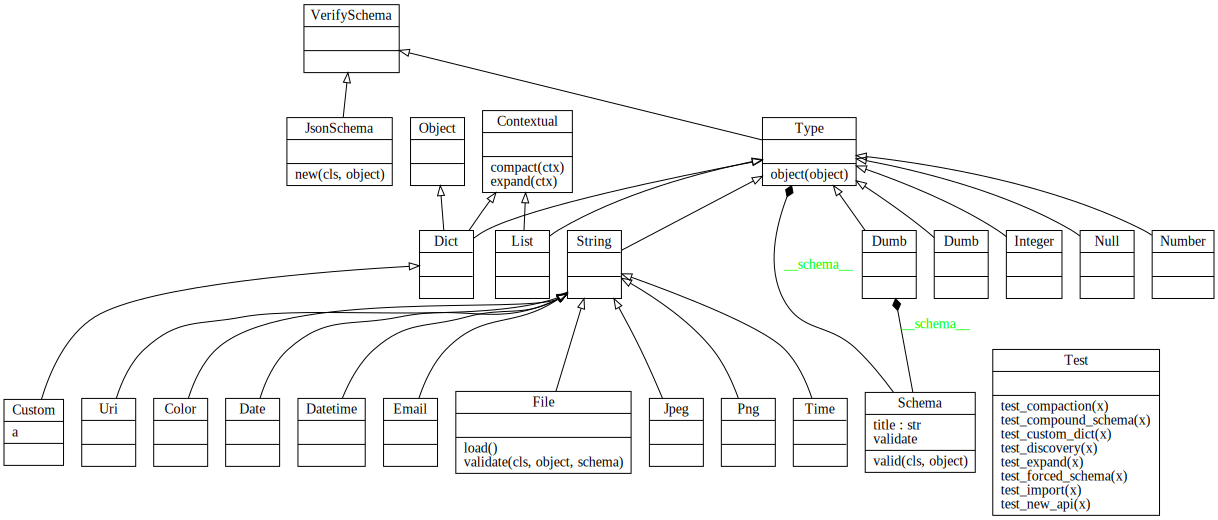

In [7]:
    if __name__ == '__main__': 
        !jupyter nbconvert --to script jschema.ipynb
        !pyreverse jschema -osvg -pjschema
        !rm jschema.py
        display(__import__('IPython').display.SVG('classes_jschema.svg'))